In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (8, 8)

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Notes and open questions

* Sensitivity of the classifier (complexity, n_samples, etc)? Assumptions on the shape of s(x)? 
    - Make a comparison
    - Increase n_estimators to increase to smoothness of s(x)
* Best way to approximate p(s(x)|theta)? Histograms or KDE? 
    - Histograms: number of bins, width? n_samples? filtering out outliers?
    - KDE: bandwidth? n_samples?
* https://github.com/jgpavez/systematics/tree/training_study
* Scatter plots of s(x) vs p(x|theta0)/p(x|theta1)
* Accuracy of the classifier vs LR fit
 

# Approximating distribution from histogram and KDE

In [5]:
class histogram_rv(object):
    def __init__(self, samples, n_bins=30, range=None):
        self.samples = samples
        self.n_bins = n_bins
        self.range = range
        
        self.hist, self.bins = np.histogram(samples, bins=n_bins, density=True, range=self.range)       
        self.hist = np.hstack(([0.], self.hist, [0.]))
        self.bins = np.hstack(([-np.inf], self.bins, [np.inf]))        
        
    def pdf(self, x):
        return self.hist[np.searchsorted(self.bins, x) - 1]

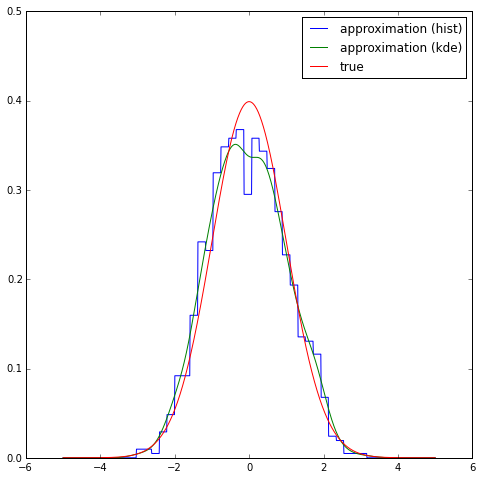

In [6]:
from scipy.stats import norm
from scipy.stats import gaussian_kde

d = np.random.normal(size=1000)
histogram = histogram_rv(d)
kde = gaussian_kde(d)

x = np.linspace(-5, 5, num=1000)

plt.plot(x, histogram.pdf(x), "b", label="approximation (hist)")
plt.plot(x, kde.pdf(x), "g", label="approximation (kde)")
plt.plot(x, norm.pdf(x), "r", label="true")
plt.ylim(0.0, 0.5)
plt.legend(loc="best")
plt.show()

# Approximating likelihood ratios

## Toy problem

In [7]:
from sklearn.utils import check_random_state

class composed_rv(object):
    def __init__(self, components, weights):
        self.components = components
        self.weights = weights
        
    def pdf(self, x):
        return sum(p_c.pdf(x) * w for p_c, w in zip(self.components, self.weights))
    
    def rvs(self, n_samples=1, random_state=None):
        random_state = check_random_state(random_state)
        
        _, c = np.where(random_state.multinomial(1, self.weights, n_samples) == 1)
        samples = []

        for i in range(n_samples):
            samples.append(self.components[c[i]].rvs(random_state=random_state))

        return np.array(samples)

In [8]:
# Define distributions
components = [norm(loc=-2.0, scale=0.75), 
              norm(loc=0.0, scale=2.0), 
              norm(loc=1.0, scale=0.75)]
w_0 = [0.5, 0.5, 0.05] 
w_1 = [0.5, 0.5, 0.0] 

w_0 = np.array(w_0)
w_0 /= w_0.sum()
w_1 = np.array(w_1)
w_1 /= w_1.sum()
    
p_theta_0 = composed_rv(components, w_0)
p_theta_1 = composed_rv(components, w_1)

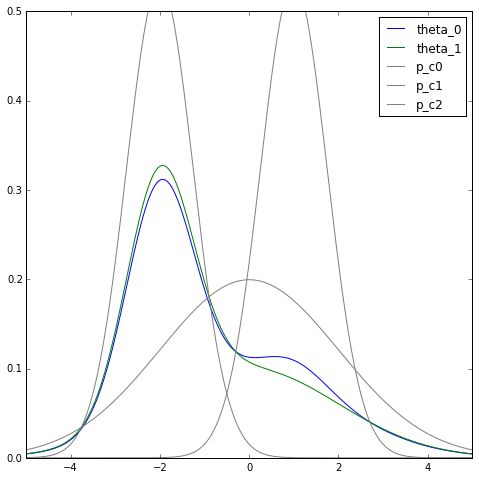

In [9]:
# Plot
x = np.linspace(-5, 5, num=1000)
plt.plot(x, p_theta_0.pdf(x), label="theta_0")
plt.plot(x, p_theta_1.pdf(x), label="theta_1")

for i, p_c in enumerate(components):
    plt.plot(x, p_c.pdf(x), "gray", label="p_c%d" % i)

plt.xlim(-5, 5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

## Using full distributions

In [10]:
def likelihood_ratio(x, p_theta_0, p_theta_1, log=True, eps=10e-7):       
    if log:
        r = np.log(p_theta_0.pdf(x) + eps) - np.log(p_theta_1.pdf(x) + eps)
    else:
        r = (p_theta_0.pdf(x) + eps) / (p_theta_1.pdf(x) + eps)
    
    return r

def likelihood_ratio_statistic(x, p_theta_0, p_theta_1, log=True, eps=10e-7):
    r = likelihood_ratio(x, p_theta_0, p_theta_1, log=log, eps=eps)
    
    if log:
        return np.sum(r)
    else:
        return np.prod(r[r != 0])

In [11]:
from sklearn.base import clone
from sklearn.utils import check_random_state

def build_p_s_theta(estimator, p_theta_0, p_theta_1, 
                    n_samples_train=1000, n_samples_approximate=100000, 
                    approximation="kde", bw_method=None, n_bins=40, random_state=123):      
    # Reset state
    random_state = check_random_state(random_state)
    
    # Build a classification task between the two full distributions
    d_0 = p_theta_0.rvs(n_samples_train, random_state=random_state).reshape((-1, 1))
    d_1 = p_theta_1.rvs(n_samples_train, random_state=random_state).reshape((-1, 1))
    X = np.vstack((d_0, d_1))
    y = np.ones(len(X))
    y[:n_samples_train] = 0

    # Build a classifier
    est = clone(estimator)
    est.fit(X, y)
    
    if not hasattr(est, "decision_function"):
        est.decision_function = lambda X: est.predict_proba(X)[:, 0]

    # Fit score distributions on new data
    d_0 = p_theta_0.rvs(n_samples_approximate, random_state=random_state).reshape((-1, 1))
    d_1 = p_theta_1.rvs(n_samples_approximate, random_state=random_state).reshape((-1, 1))

    # Approximate the full score distributions
    if approximation == "kde":
        p_s_theta_0 = gaussian_kde(est.decision_function(d_0), bw_method=bw_method)
        p_s_theta_1 = gaussian_kde(est.decision_function(d_1), bw_method=bw_method)
        
    else:
        s_0 = est.decision_function(d_0)
        s_1 = est.decision_function(d_1)
        low, high = low, high = min(s_0.min(), s_1.min()), max(s_0.max(), s_1.max())
        p_s_theta_0 = histogram_rv(s_0, n_bins=n_bins, range=(low, high)) # bins need to be aligned
        p_s_theta_1 = histogram_rv(s_1, n_bins=n_bins, range=(low, high))
        
    return est, p_s_theta_0, p_s_theta_1

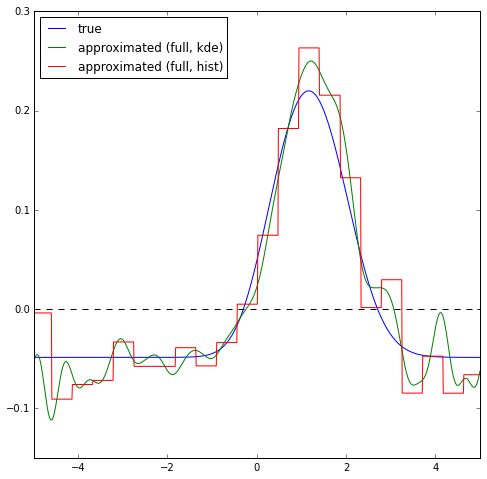

In [14]:
x = np.linspace(-5, 5, num=1000)
plt.plot([-5, 5], [0.0, 0.0], "k--")

# True ratio
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")

# Approximate ratio, estimated using KDE
from sklearn.linear_model import ElasticNetCV
estimator, p_s_theta_0_kde, p_s_theta_1_kde = build_p_s_theta(ElasticNetCV(), 
                                                              p_theta_0, 
                                                              p_theta_1, 
                                                              approximation="kde")

plt.plot(x, likelihood_ratio(estimator.decision_function(x.reshape(-1, 1)), 
                             p_s_theta_0_kde, p_s_theta_1_kde), 
         label="approximated (full, kde)")

# Approximate ratio, estimated using histograms
estimator, p_s_theta_0_hist, p_s_theta_1_hist = build_p_s_theta(ElasticNetCV(), 
                                                                p_theta_0, 
                                                                p_theta_1, 
                                                                approximation="hist")

plt.plot(x, likelihood_ratio(estimator.decision_function(x.reshape(-1, 1)), 
                             p_s_theta_0_hist, p_s_theta_1_hist), 
         label="approximated (full, hist)")

plt.xlim(-5, 5)
plt.legend(loc="best")
plt.show()

In [15]:
n_samples = 1000
d_0 = p_theta_0.rvs(n_samples).reshape((-1, 1))
d_1 = p_theta_1.rvs(n_samples).reshape((-1, 1))

print("Exact ratio statistic")
print(likelihood_ratio_statistic(d_0[:n_samples], p_theta_0, p_theta_1))
print(likelihood_ratio_statistic(d_1[:n_samples], p_theta_0, p_theta_1))
print()

print("Approximated ratio statistic (full, kde, elasticnet)")
print(likelihood_ratio_statistic(estimator.decision_function(d_0[:n_samples].reshape(-1, 1)), 
                                 p_s_theta_0_kde, p_s_theta_1_kde))
print(likelihood_ratio_statistic(estimator.decision_function(d_1[:n_samples].reshape(-1, 1)), 
                                 p_s_theta_0_kde, p_s_theta_1_kde))
print()

print("Approximated ratio statistic (full, hist, elasticnet)")
print(likelihood_ratio_statistic(estimator.decision_function(d_0[:n_samples].reshape(-1, 1)), 
                                 p_s_theta_0_hist, p_s_theta_1_hist))
print(likelihood_ratio_statistic(estimator.decision_function(d_1[:n_samples].reshape(-1, 1)), 
                                 p_s_theta_0_hist, p_s_theta_1_hist))

# Not sure if differences are due to numerical issues, imprecision of the classifiers, or other things
# But at least, orders of magnitude are OK

Exact ratio statistic
2.81240490835
-2.27755074667

Approximated ratio statistic (full, kde, elasticnet)
2.62365734608
-2.39739029776

Approximated ratio statistic (full, hist, elasticnet)
3.54520737266
-2.78974338565


## Using decomposed distributions

In [16]:
def likelihood_ratio_decomposed(x, p_c_theta_0, p_c_theta_1, w_0, w_1, log=True, eps=10e-7):
    r = np.zeros(len(x))
    
    for p_c_i_theta_0, w_i_0 in zip(p_c_theta_0, w_0):
        s = np.zeros(len(x))
        
        for p_c_j_theta_1, w_j_1 in zip(p_c_theta_1, w_1):
            s += w_j_1 * p_c_j_theta_1.pdf(x)
            
        r += (w_i_0 * p_c_i_theta_0.pdf(x) + eps) / (s + eps)
        
    if log:
        return np.log(r)
    else:
        return r

In [17]:
from sklearn.base import clone
from sklearn.utils import check_random_state

def build_p_s_ci_cj_theta(estimator, components, 
                          n_samples_train=1000, n_samples_approximate=100000, 
                          bw_method=None, random_state=123):
    # Reset state
    random_state = check_random_state(random_state)
    
    # Pairwise building
    estimators = {}
    p_s_ci_cj_theta = {}
    d_train = {}
    d_approximate = {}

    for i, p_c_i in enumerate(components):
        for j, p_c_j in enumerate(components):
            # Skip
            if i == j:
                continue

            # Build a classification task between the two components
            d_i = d_train.setdefault(i, p_c_i.rvs(n_samples_train, random_state=random_state).reshape(-1, 1))
            d_j = d_train.setdefault(j, p_c_j.rvs(n_samples_train, random_state=random_state).reshape(-1, 1))
            X = np.vstack((d_i, d_j))
            y = np.ones(len(X))
            y[:n_samples] = 0

            # Build a classifier
            est = clone(estimator)
            est.fit(X, y)
            estimators[(i, j)] = est        
            
            if not hasattr(est, "decision_function"):
                est.decision_function = lambda X: est.predict_proba(X)[:, 0]

            # Fit score distributions on new data
            d_i = d_approximate.setdefault(i, p_c_i.rvs(n_samples_approximate, random_state=random_state).reshape(-1, 1))
            d_j = d_approximate.setdefault(j, p_c_j.rvs(n_samples_approximate, random_state=random_state).reshape(-1, 1))

            # Approximate the pair score distributions 
            p_s_ci_cj_theta_0 = gaussian_kde(est.decision_function(d_i), bw_method=bw_method)
            p_s_ci_cj_theta_1 = gaussian_kde(est.decision_function(d_j), bw_method=bw_method)

            p_s_ci_cj_theta[(i, j, 0)] = p_s_ci_cj_theta_0
            p_s_ci_cj_theta[(i, j, 1)] = p_s_ci_cj_theta_1        
            
    return estimators, p_s_ci_cj_theta

In [18]:
def approximate_likelihood_ratio_decomposed(x, estimators, p_s_ci_cj_theta, w_0, w_1, log=True, eps=10e-7):
    r = np.zeros(len(x))
    
    for i, w_i_0 in enumerate(w_0):
        s = np.zeros(len(x))
        
        for j, w_j_1 in enumerate(w_1):
            if i == j:
                s += ((w_j_1 + eps) / (w_i_0 + eps)) * np.ones(len(x))
                
            else:
                est = estimators[(i, j)]
                p_s_ci_cj_theta_0 = p_s_ci_cj_theta[(i, j, 0)]
                p_s_ci_cj_theta_1 = p_s_ci_cj_theta[(i, j, 1)]
                
                s += (((w_j_1 + eps) / 
                       (w_i_0 + eps)) * 
                      ((p_s_ci_cj_theta_1.pdf(est.decision_function(x)) + eps) / 
                       (p_s_ci_cj_theta_0.pdf(est.decision_function(x)) + eps)))
                
        r += 1.0 / (s + eps)
        
    if log:
        return np.log(r)
    else:
        return r

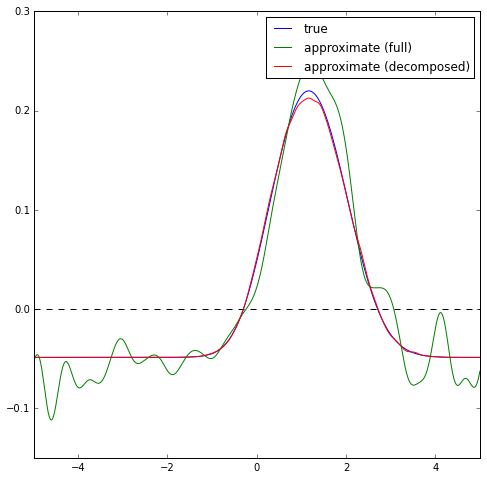

In [20]:
from sklearn.linear_model import ElasticNetCV

x = np.linspace(-5, 5, num=1000)
plt.plot([-5, 5], [0.0, 0.0], "k--")

plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")
plt.plot(x, likelihood_ratio(estimator.decision_function(x.reshape(-1, 1)), 
                             p_s_theta_0_kde, 
                             p_s_theta_1_kde), label="approximate (full)")

estimators, p_s_ci_cj_theta = build_p_s_ci_cj_theta(ElasticNetCV(), components)
plt.plot(x, approximate_likelihood_ratio_decomposed(x.reshape(-1, 1), 
                                                    estimators, 
                                                    p_s_ci_cj_theta, 
                                                    w_0, w_1), label="approximate (decomposed)")

plt.xlim(-5, 5)
plt.legend()
plt.show()

# Comparing classifiers

In [23]:
# Define distributions
components = [norm(loc=-2.0, scale=0.75), 
              norm(loc=0.0, scale=2.0), 
              norm(loc=1.0, scale=0.75)]
w_0 = [0.5, 0.5, 0.05] 
w_1 = [0.5, 0.5, 0.0] 

w_0 = np.array(w_0)
w_0 /= w_0.sum()
w_1 = np.array(w_1)
w_1 /= w_1.sum()
    
p_theta_0 = composed_rv(components, w_0)
p_theta_1 = composed_rv(components, w_1)

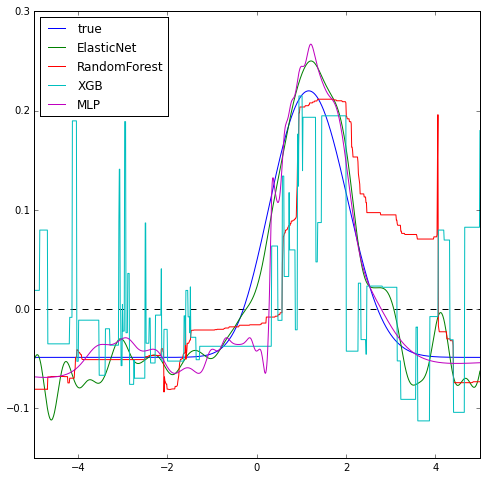

In [24]:
x = np.linspace(-5, 5, num=1000)
plt.plot([-5, 5], [0.0, 0.0], "k--")

# True ratio
plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")

# Approximate ratio
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

for name, est in [("ElasticNet", ElasticNetCV()), 
                  ("RandomForest", RandomForestClassifier(n_estimators=1000, 
                                                          max_leaf_nodes=2, 
                                                          n_jobs=-1)),
                  ("XGB", XGBClassifier(max_depth=2)),
                  ("MLP", MLPClassifier(hidden_layer_sizes=(3, 3), 
                                         activation="tanh"))]:
    estimator, p_s_theta_0, p_s_theta_1 = build_p_s_theta(est, p_theta_0, p_theta_1)
    plt.plot(x, likelihood_ratio(estimator.decision_function(x.reshape(-1, 1)), 
                                 p_s_theta_0, 
                                 p_s_theta_1), label="%s" % name)

plt.xlim(-5, 5)
plt.legend(loc="best")
plt.show()

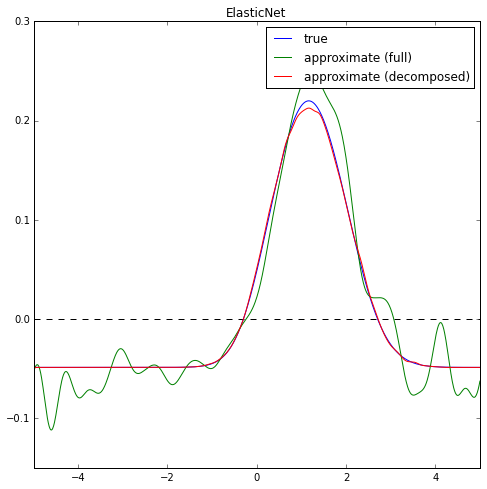

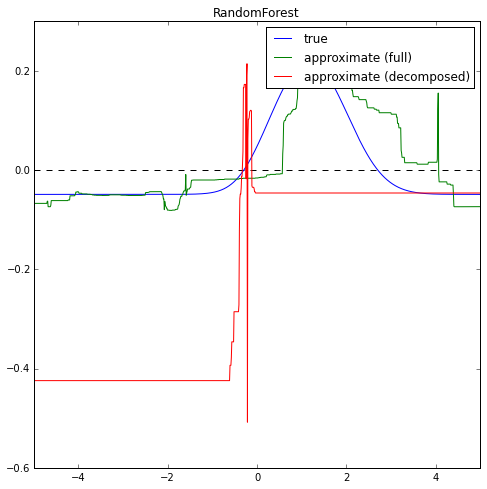

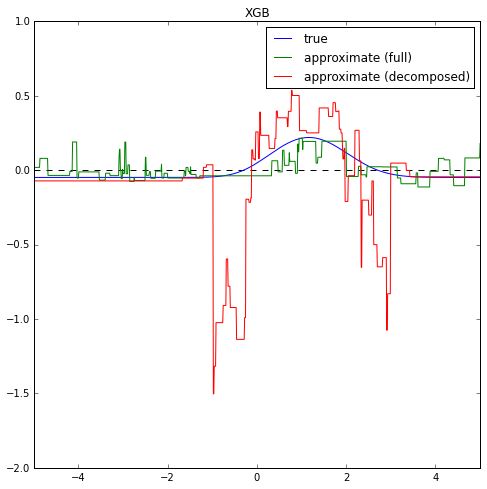

/home/gilles/src/scikit-learn/sklearn/neural_network/multilayer_perceptron.py:544: ConvergenceWarning: SGD: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


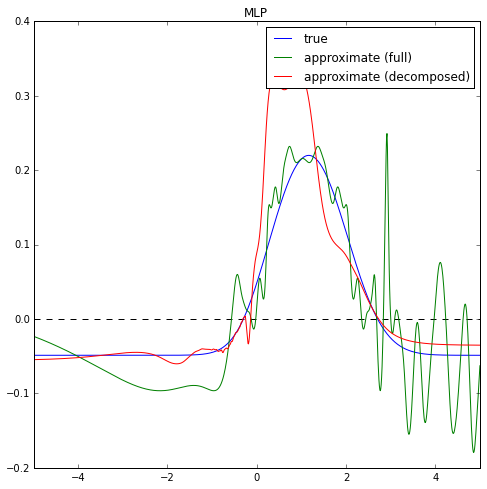

In [25]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

for name, est in [("ElasticNet", ElasticNetCV()), 
                  ("RandomForest", RandomForestClassifier(n_estimators=1000, 
                                                          max_leaf_nodes=2, 
                                                          n_jobs=-1)),
                  ("XGB", XGBClassifier(max_depth=2)),
                  ("MLP", MLPClassifier(hidden_layer_sizes=(3, 3), 
                                         activation="tanh"))]:
    x = np.linspace(-5, 5, num=1000)
    plt.plot([-5, 5], [0.0, 0.0], "k--")
    plt.plot(x, likelihood_ratio(x, p_theta_0, p_theta_1), label="true")
    
    estimator, p_s_theta_0, p_s_theta_1 = build_p_s_theta(est, p_theta_0,  p_theta_1)    
    plt.plot(x, likelihood_ratio(estimator.decision_function(x.reshape(-1, 1)), 
                                 p_s_theta_0, 
                                 p_s_theta_1), label="approximate (full)")

    estimators, p_s_ci_cj_theta = build_p_s_ci_cj_theta(est, components)
    plt.plot(x, approximate_likelihood_ratio_decomposed(x.reshape(-1, 1), 
                                                        estimators, 
                                                        p_s_ci_cj_theta, 
                                                        w_0, w_1), label="approximate (decomposed)")

    plt.xlim(-5, 5)
    plt.title(name)
    plt.legend()
    plt.show()

# Study monotonicity of s(x) with p(x|t0) / p(x|t1)

In [42]:
# Define distributions
components = [norm(loc=-2.0, scale=0.75), 
              norm(loc=0.0, scale=2.0), 
              norm(loc=1.0, scale=0.75)]
w_0 = [1.5, 0.5, 0.05] 
w_1 = [0.5, 0.5, 0.0] 

w_0 = np.array(w_0)
w_0 /= w_0.sum()
w_1 = np.array(w_1)
w_1 /= w_1.sum()
    
p_theta_0 = composed_rv(components, w_0)
p_theta_1 = composed_rv(components, w_1)

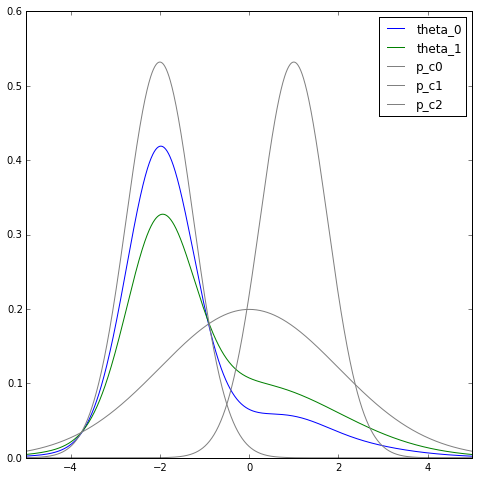

In [44]:
# Plot
x = np.linspace(-5, 5, num=1000)
plt.plot(x, p_theta_0.pdf(x), label="theta_0")
plt.plot(x, p_theta_1.pdf(x), label="theta_1")

for i, p_c in enumerate(components):
    plt.plot(x, p_c.pdf(x), "gray", label="p_c%d" % i)

plt.xlim(-5, 5)
plt.legend()
plt.show()

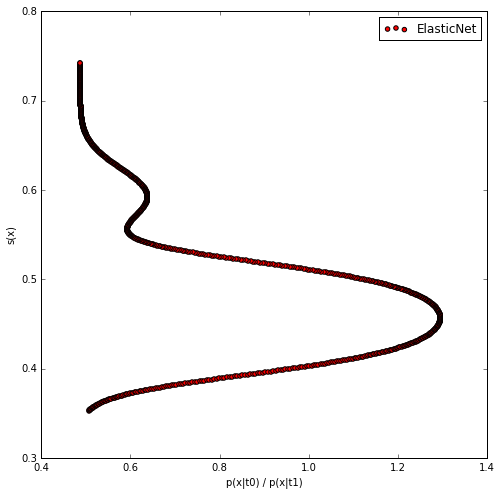

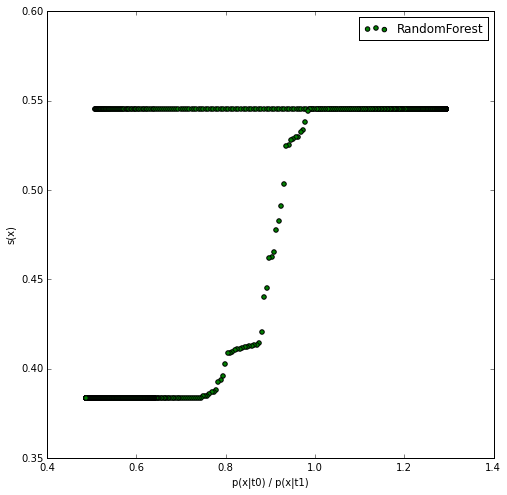

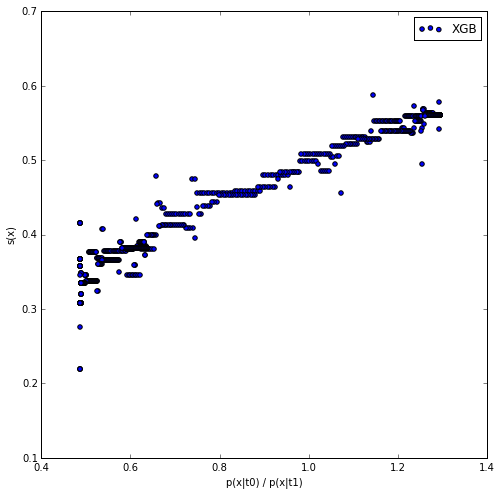

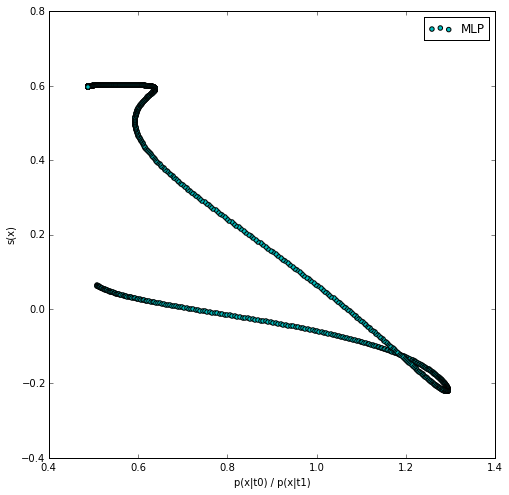

In [51]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

colors = ["r", "g", "b", "c", "y", "m", "k"]
x = np.linspace(-5, 5, num=1000)

for i, (name, est) in enumerate([("ElasticNet", ElasticNetCV()), 
                                 ("RandomForest", RandomForestClassifier(n_estimators=1000, 
                                                                         max_leaf_nodes=2, 
                                                                         n_jobs=-1)),
                                 ("XGB", XGBClassifier(max_depth=2)),
                                 ("MLP", MLPClassifier(hidden_layer_sizes=(3, 3), 
                                                       activation="tanh"))]):
    estimator, _, _ = build_p_s_theta(est, p_theta_0, p_theta_1, n_samples_train=50000)
    plt.scatter(p_theta_0.pdf(x) / p_theta_1.pdf(x),
                estimator.decision_function(x.reshape(-1, 1)), label=name, c=colors[i])
    
    plt.xlabel("p(x|t0) / p(x|t1)")
    plt.ylabel("s(x)")
    plt.legend(loc="best")
    plt.show()